In [1]:
!pip install transformers scikit-plot

In [2]:
import os
import time
import random
import string
import re

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve
import scikitplot as skplt

from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import AutoConfig
from transformers import get_scheduler

import matplotlib.pyplot as plt


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import data


In [3]:
# Define paths
fake_path = "/workspaces/fatima-fellowship/src/nlp/data/Fake.csv"
true_path = "/workspaces/fatima-fellowship/src/nlp/data/True.csv"

# Create dataframes
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Manipulate data


In [4]:
# Add labels
fake_df['label'] = 0
true_df['label'] = 1

# Concatenate dataframes
df = pd.concat([fake_df, true_df], axis=0)

# Drop duplicates and na
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Explore data


In [8]:
# Explore data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [14]:
df['date']

0        December 31, 2017
1        December 31, 2017
2        December 30, 2017
3        December 29, 2017
4        December 25, 2017
               ...        
21412     August 22, 2017 
21413     August 22, 2017 
21414     August 22, 2017 
21415     August 22, 2017 
21416     August 22, 2017 
Name: date, Length: 44689, dtype: object

In [17]:
# date column
# extract year
df['year'] = df['date'].apply(lambda x: str(x).split()[-1])

df['year'].unique()

array(['2017', '2016', '19-Feb-18', '18-Feb-18', '17-Feb-18', '16-Feb-18',
       '15-Feb-18', '14-Feb-18',
       'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/',
       '2015',
       'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/',
       'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg',
       '[Video]'], dtype=object)

In this task, we want to classify the text despite the date of the news, so date is ommited. 

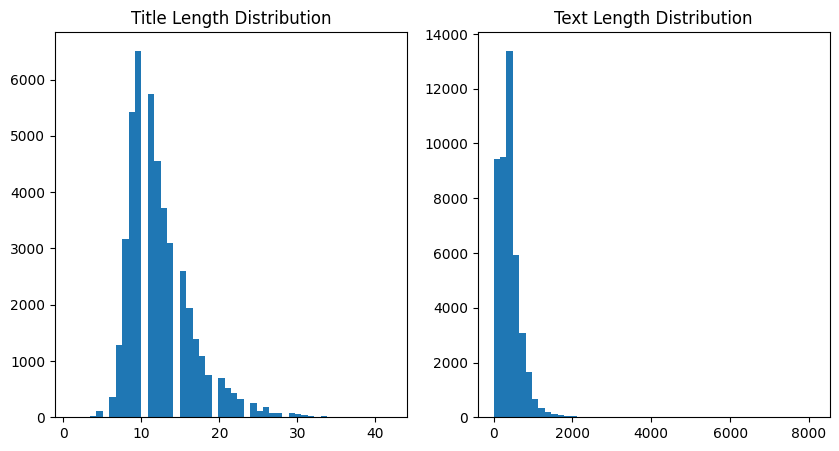

In [20]:
# Explore the title and text columns
# Eliminate spaces and punctuation
df['title_len'] = df['title'].apply(lambda x: len(re.sub(r'[^\w\s]','',x).split()))
df['text_len'] = df['text'].apply(lambda x: len(re.sub(r'[^\w\s]','',x).split()))

# Plot the distribution of the number of words of the title and text columns
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df['title_len'], bins=50)
plt.title('Title Length Distribution')
plt.subplot(1,2,2)
plt.hist(df['text_len'], bins=50)
plt.title('Text Length Distribution')
plt.show()



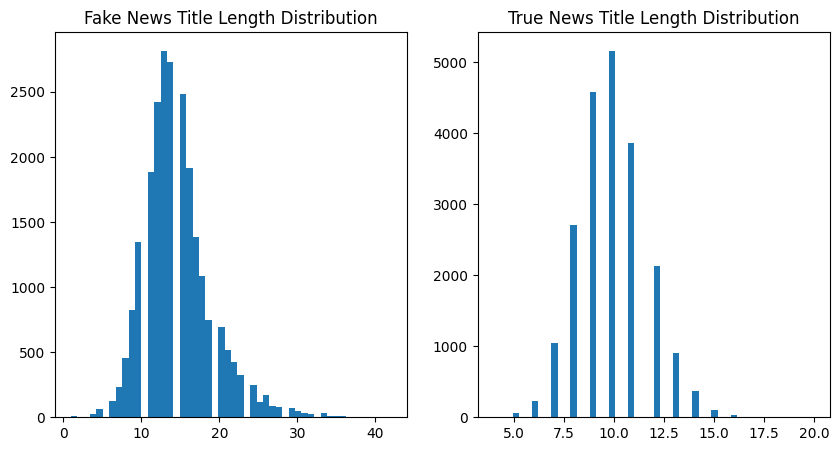

In [21]:
# Plot the distribution of true and fake news
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df[df['label']==0]['title_len'], bins=50)
plt.title('Fake News Title Length Distribution')
plt.subplot(1,2,2)
plt.hist(df[df['label']==1]['title_len'], bins=50)
plt.title('True News Title Length Distribution')
plt.show()

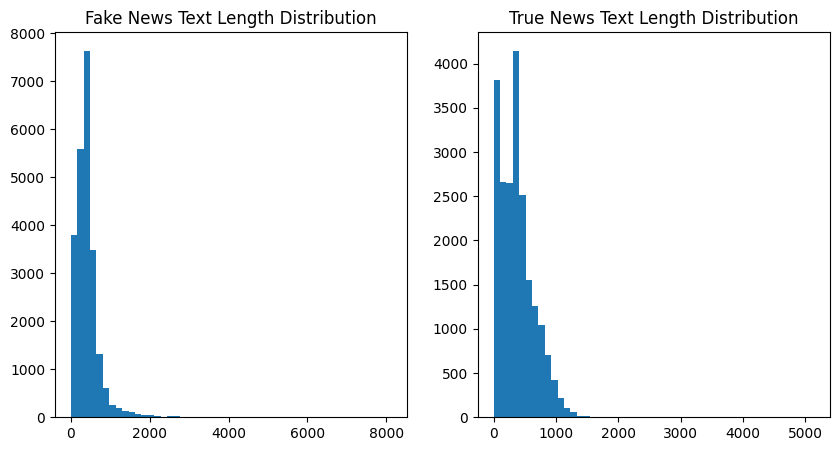

In [22]:
# Plot the distribution of true and fake news
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df[df['label']==0]['text_len'], bins=50)
plt.title('Fake News Text Length Distribution')
plt.subplot(1,2,2)
plt.hist(df[df['label']==1]['text_len'], bins=50)
plt.title('True News Text Length Distribution')
plt.show()

# Dataset split

In [14]:
# split dataset into train, val and test set
train, val, test = np.split(df.sample(frac=1, random_state = 42), [int(.6*len(df)), int(.8*len(df))])

# Model

In [9]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
class TrainDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.df.iloc[index]['text']
        target = self.df.iloc[index]['label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
        )
        
        text_ids = encoding['input_ids']
        text_mask = encoding['attention_mask']

        return {
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.float)
        }

In [18]:
class FakeNewsClassifier(nn.Module):

    def __init__(self, model, num_classes=2):
        super().__init__()
        self.model = model
        self.embbeding_dim = self.model.config.hidden_size
        self.num_classes = num_classes
        self.dropout = nn.Dropout(0.1)  # dropout layer to prevent overfitting
        self.fc = nn.Linear(self.embedding_dim, self.num_classes)

    def forwward(self, text_ids, text_mask):
        outputs = self.model(text_ids, attention_mask=text_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0] # get the [CLS] token representation

    
    def __init__(self, model_name, num_classes=2):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)  # dropout layer to prevent overfitting
        embedding_dim = self.bert.config.hidden_size
        self.fc = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, text_ids, text_mask):
        outputs = self.bert(text_ids, attention_mask=text_mask)
        hidden_state = outputs.last_hidden_state
        pooled_output = hidden_state[:, 0]  # get the [CLS] token representation
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

In [12]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    epoch_loss = 0.0

    loss_function = torch.nn.CrossEntropyLoss()
    
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Training Epoch {epoch}")
    
    for step, batch in progress_bar:
        text_ids = batch['text_ids'].to(device)
        text_mask = batch['text_mask'].to(device)
        targets = batch['target'].to(device).long()
        
        optimizer.zero_grad()
        
        logits = model(text_ids, text_mask)
        loss = loss_function(logits, targets)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({'Epoch Loss': epoch_loss / (step + 1)})
    
    return epoch_loss / len(dataloader)


@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    epoch_loss = 0.0
    loss_function = torch.nn.CrossEntropyLoss()
    
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Validating Epoch {epoch}")
    
    with torch.no_grad():
        for step, batch in progress_bar:
            text_ids = batch['text_ids'].to(device)
            text_mask = batch['text_mask'].to(device)
            targets = batch['target'].to(device).long()
            
            logits = model(text_ids, text_mask)
            loss = loss_function(logits, targets)
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({'Epoch Loss': epoch_loss / (step + 1)})
    
    return epoch_loss / len(dataloader)

In [13]:
import time
import copy
from torch.utils.data import DataLoader

def run_training(model, optimizer, scheduler, train_dataloader, valid_dataloader, device, num_epochs, PATH='best_model.pth'):
    history = {'Train loss': [], 'Valid loss': []}
    best_model = None
    best_epoch_loss = float('inf')
    
    start_time = time.time()

    for epoch in range(num_epochs):
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, train_dataloader, device, epoch)
        valid_epoch_loss = valid_one_epoch(model, valid_dataloader, device, epoch)
        
        history['Train loss'].append(train_epoch_loss)
        history['Valid loss'].append(valid_epoch_loss)
        
        if valid_epoch_loss < best_epoch_loss:
            best_epoch_loss = valid_epoch_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, PATH)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    print(f"Best Validation Loss: {best_epoch_loss:.4f}")
    
    model.load_state_dict(best_model)
    return model, history

In [16]:
import torch.optim.lr_scheduler as lr_scheduler

def create_scheduler(optimizer, num_epochs, num_training_steps):
    return lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_training_steps)

In [17]:
max_len = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataloaders
train_dataset = TrainDataset(train, tokenizer, 256)
valid_dataset = TrainDataset(val, tokenizer, 256)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

# Model
#model = FakeNewsClassifier(model_name)
model.to(device)
torch.cuda.empty_cache()

# Optimizer
# Hyperparameters
max_len = 256
batch_size = 16
num_epochs = 3
learning_rate = 2e-5
warmup_proportion = 0.1

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Create the scheduler
scheduler = create_scheduler(optimizer, num_epochs, len(train_dataloader))

# Run training
model, history = run_training(model, optimizer, scheduler, train_dataloader, valid_dataloader, device, num_epochs)





NameError: name 'FakeNewsClassifier' is not defined